https://github.com/dgerosa/astrostatistics_bicocca_2022/blob/main/lectures/L22_deeplearning.ipynb

# P11: Introduction to ML

In this problem sheet, we will revisit photometric redshift estimation and we will train a simple NN to estimate galaxy redshift from $\mathrm{mag}_u, \mathrm{mag}_g, \mathrm{mag}_r, \mathrm{mag}_i, \mathrm{mag}_z$ photometry. We will use the spectroscopic SDSS galaxy sample as an example.

For this, we will need `astroML` and `pytorch` (if you are more familar with another Deep Learning package you can of course use that instead).

## Problem 1: Get SDSS data using `astroML`

The python package `astroML` contains a number of useful data sets. In particular, it contains a sample of SDSS galaxies for which both photometric and spectroscopic measurements have been obtained. For all galaxies in this sample, we have access to photometrically-determined magnitudes $\mathrm{mag}_u, \mathrm{mag}_g, \mathrm{mag}_r, \mathrm{mag}_i, \mathrm{mag}_z$ and spectroscopically-determined redshift $z$. We will use this sample to train a neural network to predict redshift $z$ from 5 input magnitudes $\mathrm{mag}_u, \mathrm{mag}_g, \mathrm{mag}_r, \mathrm{mag}_i, \mathrm{mag}_z$, treating the spectroscopically determined redshift as ground truth.

(i) Fetch the matched SDSS sample from `astroML.datasets` making use of the routine `fetch_sdss_specgals()`.

(ii) Inspect the data set, retrieve the magnitudes $\mathrm{mag}_u, \mathrm{mag}_g, \mathrm{mag}_r, \mathrm{mag}_i, \mathrm{mag}_z$ and redshift $z$.

(iii) Plot the redshift distribution of the SDSS galaxies.

(iv) Plot the color-magnitude diagram $\mathrm{mag}_r$ vs. $\mathrm{mag}_u-\mathrm{mag}_r$ of the galaxies. What do you notice?

## Solution 1

(i)

In [1]:
from astroML import datasets
import numpy as np
import torch
import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata

from astroML.datasets import fetch_sdss_specgals
from astroML.utils.decorators import pickle_results

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

/homes/kneralwar/anaconda3/lib/python3.7/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
data = datasets.fetch_sdss_specgals()

(ii)

In [3]:
mag_u = data['modelMag_u']
mag_g = data['modelMag_g']
mag_r = data['modelMag_r']
mag_i = data['modelMag_i']
mag_z = data['modelMag_z']

z = data['z']


(iii)

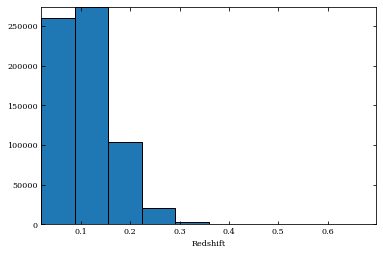

In [4]:
plt.figure()
plt.hist(z)
plt.xlabel('Redshift')
plt.show()

(iv)

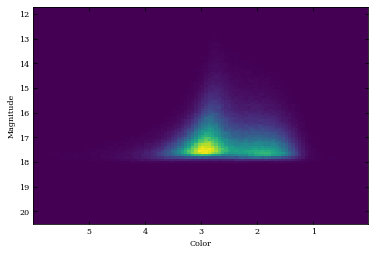

In [22]:
plt.figure()
plt.hist2d(mag_u - mag_r, mag_r, bins = 100)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Color')
plt.ylabel('Magnitude')
plt.show()

The figure shows the bimodal distribution of galaxies into red and blue ones.

## Problem 2: Build NN with `pytorch`

Use `pytorch` to build a neural network consisting of an input layer (the data itself), a hidden linear layer, and a linear output layer. As activation function, you can use ReLU. Following what we discussed in class, it is simplest if you do not apply the activation function to the output layer.

Below you can find a code snippet that defines your NN. The initialization step defines the pieces needed for your network and the `forward` function describes how to combine them in the forward pass through the NN.

In [7]:
device = 'cpu'
print(f"Using {device} device")

Using cpu device


In [8]:
class model_1hl(nn.Module):
    def __init__(self, nh1):
        '''
        Class initialization.
        Args:
        nh1 (:obj:`integer`): number of neurons in hidden layer
        '''
        
        super().__init__() # Call base class' init function
        self.fc_h = nn.Linear(5,nh1) # Linear hidden layer (use nn.Linear)
        self.fc_o = nn.Linear(nh1, 1) # Linear output layer

    def forward(self, x):
        h = F.relu(self.fc_h(x)) # Apply ReLU to output from fc_h (use nn.ReLU)
        z = self.fc_o(h)# Pass h though output layer
        return z

In [9]:
model = model_1hl(4).to(device)
print(model)

model_1hl(
  (fc_h): Linear(in_features=5, out_features=4, bias=True)
  (fc_o): Linear(in_features=4, out_features=1, bias=True)
)


## Problem 3: Data preparation

In this problem, we will prepare our data for NN training.

(i) Split the data from problem 1 into three subsamples: training set, validation set, and test set. As a first approach you can use $70\%$ of the data for training, and $15\%$ each for validation and testing.

(ii) NN training is often more efficient when using normalized data, as this improves the performance of gradient descent algorithms. Using the data from (i), normalize it to zero mean and variance 1. **Hint:** Discuss when normalization should be applied and how to normalize the validation and test sets.

**Hint:** To interface with `pytorch`, you can either use the functionality provided by `TensorDataset` and `tensor`, or you can also define your own dataset class. Once you have created your dataset, you can create a data loader using `DataLoader`. 

In [10]:
datareq = np.zeros((len(data), 6), dtype=np.float32)

for i, band in enumerate(['u', 'g', 'r', 'i', 'z']):
    band = 'modelMag_' + band
    datareq[:, i] = data[band]
    
datareq[:, 5] = data['z']    

traindata_array = datareq[:int(0.7*len(datareq))]
valdata_array = datareq[int(0.7*len(datareq)):int(0.85*len(datareq))]
testdata_array = datareq[int(0.85*len(datareq)):]

We want to use only the information from the traindataset for the training. Thus we use the normalisation factors (mean and std) from the training data to normalise all the datasets. 

In [11]:
traindata_norm = (traindata_array[:,0:5] - np.mean(traindata_array[:,0:5] , axis = 0)) / np.std(traindata_array[:,0:5] , axis = 0)
valdata_norm = (valdata_array[:,0:5] - np.mean(traindata_array[:,0:5] , axis = 0)) / np.std(traindata_array[:,0:5] , axis = 0)
testdata_norm = (testdata_array[:,0:5] - np.mean(traindata_array[:,0:5] , axis = 0)) / np.std(traindata_array[:,0:5] , axis = 0)

In [12]:
train_z = traindata_array[:,5]
train_z = (train_z[:, np.newaxis])
traindata =  (np.append(traindata_norm, train_z, axis = 1))

val_z = valdata_array[:,5]
val_z = (val_z[:, np.newaxis])
valdata =  (np.append(valdata_norm, val_z, axis = 1))

test_z = testdata_array[:,5]
test_z = (test_z[:, np.newaxis])
testdata = (np.append(testdata_norm, test_z, axis = 1))

In [13]:
traindataset = torchdata.TensorDataset(torch.tensor(traindata[:, 0:5]),
                                  torch.tensor(traindata[:, 5]).view(-1, 1))

valdataset = torchdata.TensorDataset(torch.tensor(valdata[:, 0:5]),
                                  torch.tensor(valdata[:, 5]).view(-1, 1))

testdataset = torchdata.TensorDataset(torch.tensor(testdata[:, 0:5]),
                                  torch.tensor(testdata[:, 5]).view(-1, 1))

traindataloader = torchdata.DataLoader(traindataset, 
                                       batch_size=128, 
                                       shuffle=True)


## Problem 4: NN training

In this problem, we will write a routine to train our NN with `pytorch`. Note the following:

- As loss function, you can use the mean squared error.
- You can use the stochastic gradient descent optimizer.
- Log the training, validation and test loss for each epoch as numpy arrays.
- Use the validation loss to pick the optimal model for a given architecture and choice of hyperparameters, i.e. pick the model with the lowest validation loss.

(i) Once you have set up the training routine, train your model for 100 epochs and save the best-performing model.

(ii) Look at the loss curves as a function of training epoch and discuss your results. Have you trained the model long enough?

(iii) Experiment with changing hyperparameters, especially the learning rate.

In [14]:
def train_NN(lr = 0.001, epochs = 10):
    # 4 neurons
    model = model_1hl(4)
    # MSE loss
    criterion = torch.nn.MSELoss(reduction='sum') 
    # stochastic gradient descent
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    # Adaptive learning rate...
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           verbose=True, 
                                                           patience=5, 
                                                           threshold=1e-3)

    min_valid_loss = float('inf')
    badepochs = 0
    train_loss_array = []
    valid_loss_array = []
    for t in range(epochs):
        train_loss = 0
        for i, databatch in enumerate(traindataloader, 0):
            photometry, redshifts = databatch
            optimizer.zero_grad()
            z_pred = model(photometry) #training
            loss = criterion(z_pred, redshifts) #loss calculation
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
#testing
            
        with torch.no_grad():
            photometry = valdataset[:][0]
            redshifts = valdataset[:][1]
            z_pred = model(photometry)
            valid_loss = criterion(z_pred, redshifts)
            train_loss_array.append(train_loss / len(traindataset))
            valid_loss_array.append(valid_loss / len(valdataset))
            if t % 10 == 0:
                print('Epoch %3i: train loss %0.3e validation loss %0.3e' % (t, \
                        train_loss / len(traindataset), valid_loss / len(valdataset)))
            # stop training if validation loss has not fallen in 10 epochs
            if valid_loss > min_valid_loss*(1-1e-3):
                badepochs += 1
            else:
                min_valid_loss = valid_loss
                badepochs = 0
            if badepochs == 10:
                print('Finished training')
                break
        scheduler.step(valid_loss)
    return model, train_loss_array, valid_loss_array

In [15]:
model_trained, train_loss, valid_loss = train_NN(epochs = 100)

Epoch   0: train loss 1.634e-03 validation loss 1.327e-03
Epoch  10: train loss 9.082e-04 validation loss 8.624e-04
Epoch  20: train loss 8.956e-04 validation loss 8.717e-04
Epoch  30: train loss 8.854e-04 validation loss 8.450e-04
Epoch  40: train loss 6.085e-04 validation loss 5.945e-04
Epoch  50: train loss 5.897e-04 validation loss 5.800e-04
Epoch    54: reducing learning rate of group 0 to 1.0000e-04.
Finished training


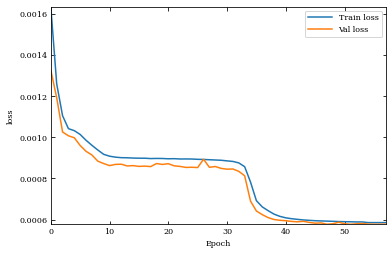

In [16]:
plt.figure()
plt.plot(train_loss, label = 'Train loss')
plt.plot(valid_loss, label = 'Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

## Problem 5: Evaluate the performance of your model 

Use the test set to evaluate the performance of your NN.

In [17]:
with torch.no_grad():
    photometry = testdataset[:][0]
    redshifts = testdataset[:][1]
    z_pred = model_trained(photometry)
    criterion = torch.nn.MSELoss(reduction='sum') 
    test_loss = criterion(z_pred, redshifts)
    print('Test loss %0.3e ' % (test_loss / len(testdataset)))
    

Test loss 5.705e-04 


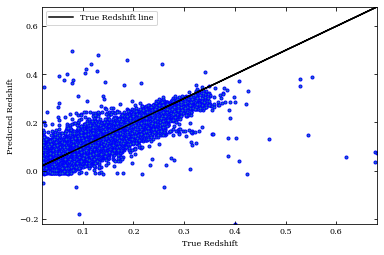

In [18]:
plt.figure()
plt.scatter(redshifts, z_pred, marker ='.')
plt.plot(redshifts, redshifts, label = 'True Redshift line', c = 'k')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.legend()
plt.show()